In [ ]:
import nltk
from konlpy.tag import *
from ckonlpy.tag import Twitter
import MeCab
import kss
from collections import Counter
import tensorflow as tf
import numpy as np
import re
from soynlp.normalizer import *
import hanspell
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from math import log
import urllib
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint
import platform
from tqdm.notebook import tqdm

plt.style.use("dark_background")

okt = Okt()
kkm = Kkma()
kmr = Komoran()
hnn = Hannanum()
twt = Twitter()

class Mecab:
    def pos(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def morphs(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [p.match(line).group().split("\t")[0] for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def nouns(self, text):
        p = re.compile(".+\t[A-Z]+")
        temp = [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
        nouns=[]
        for word in temp:
            if word[1] in ["NNG", "NNP", "NNB", "NNBC", "NP", "NR"]:
                nouns.append(word[0])
        return nouns
    
mc = Mecab()

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Darwin":
    mpl.rc("font", family="AppleGothic")
elif platform.system() == "Windows":
    font_name = mpl.font_manager.FontProperties(fname=path).get_name()
    mpl.rc('font', family=font_name)
    
mpl.rc("axes", unicode_minus=False)

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\5CG7092POZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\5CG7092POZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\5CG7092POZ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 5. soynlp

## 5-1. OOV 문제

In [ ]:
print(okt.morphs("에이비식스 이대휘 1월 최애돌 기부 요정"))

NameError: name 'okt' is not defined

- 에이비식스는 아이돌의 이름이고, 이대휘는 에이비식스의 멤버이며, 최애돌은 최고로 애정하는 아이돌이라는 뜻이지만 위의 형태소 분석 결과에서는 전부 분리된 결과를 보여줍니다.
- 그렇다면 텍스트 데이터에서 특정 문자 시퀀스가 함께 자주 등장하는 빈도가 높고, 앞 뒤로 조사 또는 완전히 다른 단어가 등장하는 것을 고려해서 해당 문자 시퀀스를 형태소라고 판단하는 형태소 분석기라면 어떨까요?
- 예를 들어 에이비식스라는 문자열이 자주 연결되어 등장한다면 형태소라고 판단하고, 또한 에이비식스라는 단어 앞, 뒤에 "최고", "가수", "실력"과 같은 독립된 다른 단어들이 계속해서 등장한다면 에이비식스를 형태소로 파악하는 식이지요. 그리고 이런 아이디어를 가진 형태소 분석기가 soynlp입니다.
- soynlp는 품사 태깅, 형태소 분석 등을 지원하는 한국어 형태소 분석기입니다. 비지도 학습으로 형태소 분석을 한다는 특징을 갖고 있으며, 데이터에 자주 등장하는 단어들을 형태소로 분석합니다. soynlp 형태소 분석기는 내부적으로 단어 점수 표로 동작합니다. 이 점수는 응집 확률(cohesion probability)과 브랜칭 엔트로피(branching entropy)를 활용합니다.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")

('2016-10-20.txt', <http.client.HTTPMessage at 0x131981bfd08>)

다운로드 한 말뭉치를 문서 단위로 분리합니다.

In [ ]:
from soynlp import DoublespaceLineCorpus

# 말뭉치에 대해서 다수의 문서로 분리
corpus = DoublespaceLineCorpus("2016-10-20.txt")

len(corpus)

30091

총 3만 91개의 문서가 존재합니다. 공백이 아닌 문서에 한해 상위 3개의 문서만 출력해봅시다.

In [ ]:
i = 0
for document in corpus:
  if len(document) > 0:
    print(document)
    i = i+1
  if i == 3:
    break

19  1990  52 1 22
오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다 독자제공 영상 캡처 연합뉴스  서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다  경찰에 따르면 성씨는 19일 오후 강북경찰서 인근 부동산 업소 밖에서 부동산업자 이모 67 씨가 나오기를 기다렸다 이씨와는 평소에도 말다툼을 자주 한 것으로 알려졌다  이씨가 나와 걷기 시작하자 성씨는 따라가면서 미리 준비해온 사제 총기를 이씨에게 발사했다 총알이 빗나가면서 이씨는 도망갔다 그 빗나간 총알은 지나가던 행인 71 씨의 배를 스쳤다  성씨는 강북서 인근 치킨집까지 이씨 뒤를 쫓으며 실랑이하다 쓰러뜨린 후 총기와 함께 가져온 망치로 이씨 머리를 때렸다  이 과정에서 오후 6시 20분께 강북구 번동 길 위에서 사람들이 싸우고 있다 총소리가 났다 는 등의 신고가 여러건 들어왔다  5분 후에 성씨의 전자발찌가 훼손됐다는 신고가 보호관찰소 시스템을 통해 들어왔다 성범죄자로 전자발찌를 차고 있던 성씨는 부엌칼로 직접 자신의 발찌를 끊었다  용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기  신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다  김 경위는 오패산 터널 입구 오른쪽의 급경사에서 성씨에

soynlp는 비지도학습 형태소 분석기이므로 기존의 형태소 분석기와는 달리 학습 과정을 거쳐야 합니다. 이는 전체 코퍼스로부터 응집 확률과 브랜칭 엔트로피 단어 점수표를 만드는 과정이지요. WordExtractor.extract()를 통해서 전체 코퍼스에 대해 단어 점수표를 계산합니다.

In [ ]:
from soynlp.word import WordExtractor
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

training was done. used memory 5.186 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598


## soynlp의 응집 확률(cohesion probability)

응집 확률은 내부 문자열(substring)이 얼마나 응집하여 자주 등장하는지를 판단하는 척도입니다. 응집 확률은 문자열을 문자 단위로 분리하여 내부 문자열을 만드는 과정에서 왼쪽부터 순서대로 문자를 추가하면서 각 문자열이 주어졌을 때 그 다음 문자가 나올 확률을 계산하여 누적곱을 한 값입니다. 이 값이 높을수록 전체 코퍼스에서 이 문자열 시퀀스는 하나의 단어로 등장할 가능성이 높습니다. 수식은 아래와 같습니다. 

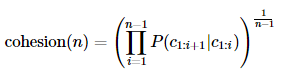

In [ ]:
from IPython.display import Image

Image("https://wikidocs.net/images/page/84111/soynlp.png")

아직은 아리송 할 거에요. "반포한강공원에"라는 7의 길이를 가진 문자 시퀀스에 대해서 각 내부 문자열의 스코어를 구하는 과정은 아래와 같습니다.

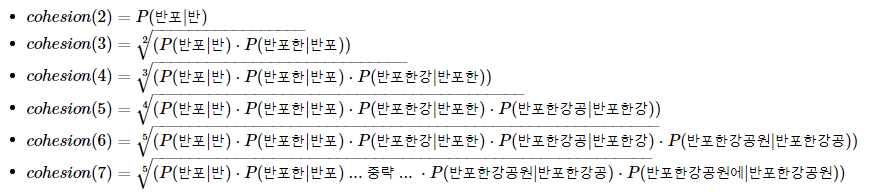

In [ ]:
Image("https://wikidocs.net/images/page/84111/soynlp2.png")

실습을 통해 직접 응집 확률을 계산해보겠습니다.

In [ ]:
word_score_table["반포한"].cohesion_forward

0.08838002913645132

In [ ]:
word_score_table["반포한강"].cohesion_forward

0.19841268168224552

In [ ]:
word_score_table["반포한강공"].cohesion_forward

0.2972877884078849

In [ ]:
word_score_table["반포한강공원"].cohesion_forward

0.37891487632839754

In [ ]:
word_score_table["반포한강공원에"].cohesion_forward

0.33492963377557666

## soynlp의 브랜칭 엔트로피(branching entropy)

Branching Entropy는 확률 분포의 엔트로피값을 사용합니다.  이는 주어진 문자열에서 얼마나 다음 문자가 등장할 수 있는지를 판단하는 척도입니다. 이해를 위해 퀴즈를 내보겠습니다. 제가 어떤 단어를 생각 중인데, 한 문자씩 말해드릴테니까 매번 다음 문자를 맞추는 것이 퀴즈입니다.

첫번째 문자는 "디"입니다. 다음에 등장할 문자를 맞춰보세요. 솔직히 가늠이 잘 안 가지요? "디"로 시작하는 단어가 얼마나 많은데요. 이걸 어떻게 맞추냐구요. 정답은 "스" 입니다.

이제 "디스"까지 나왔네요. "디스 "다음 문자는 뭘까요? 벌써 정답 단어를 예측한 분도 있을테고, 여전히 가늠이 잘 안가시는 분도 있을 거에요. "디스카운트"라는 단어가 있으니까 "카"일까? 아니면 "디스코드"라는 단어가 있으니까 "코"인가? 생각해보니 "디스코"가 정답일 수도 있겠네요. 그러면 "코"인가? "디스아너드"라는 게임이 있으니까 "아"? 전부 땡땡땡! 이 단어들을 생각하신 분들은 전부 틀렸습니다. 정답은 "플"이었습니다.

"디스플"까지 왔습니다. 다음 문자 맞춰보세요. 이제 좀 명백해지는군요. 이 정도 되면 헷갈리시는 분들은 거의 없을거에요. 정답은 "레"입니다. "디스플레" 다음에는 어떤 문자일까요? 너무 명백해서 문제라고 보기도 어려워졌어요. 정답은 "이"입니다. 제가 생각한 단어는 "디스플레이"였습니다!

저는 지금 브랜칭 엔트로피를 시뮬레이션한 겁니다. 브랜칭 엔트로피를 주어진 문자 시퀀스에서 다음 문자 예측을 위해 헷갈리는 정도로 비유해봅시다. 브랜칭 엔트로피의 값은 하나의 완성된 단어에 가까워질수록 문맥으로 인해 점점 정확히 예측할 수 있게 되면서 점점 줄어듭니다. 실습해볼게요.

In [ ]:
word_score_table["디스"].right_branching_entropy

1.6371694761537934

In [ ]:
word_score_table["디스플"].right_branching_entropy

-0.0

"디스" 다음에는 다양한 문자가 올 수 있으니까 1.63이라는 값을 가지는 반면, "디스플"이라는 문자열 다음에는 다음 문자로 "레"가 오는 것이 너무나 명백하기 때문에 0이란 값을 가집니다.

In [ ]:
word_score_table["디스플레"].right_branching_entropy

-0.0

In [ ]:
word_score_table["디스플레이"].right_branching_entropy

3.1400392861792916

갑자기 값이 급증합니다. 그 이유는 문자 시퀀스 "디스플레이"라는 문자 시퀀스 다음에는 조사나 다른 단어와 같은 다양한 경우가 있을 수 있기 때문입니다. 이는 하나의 단어가 끝나면 그 경계 부분부터 다시 브랜칭 엔트로피 값이 증가하게 됨을 의미합니다. 그리고 이 값으로 단어를 판단하는 것이 가능하겠죠?

## soynlp의 L tokenizer

한국어는 띄어쓰기 단위로 나눈 어절 토큰은 주로 L 토큰 + R 토큰의 형식을 가질 때가 많습니다. 예를 들어서 "공원에"는 "공원 + 에"로 나눌 수 있겠지요. 또는 "공부하는"은 "공부 + 하는"으로 나눌 수도 있을 것입니다. L 토크나이저는 L 토큰 + R 토큰으로 나누되, 분리 기준을 점수가 가장 높은 L 토큰을 찾아내는 원리를 가지고 있습니다.

In [ ]:
from soynlp.tokenizer import LTokenizer

scores = {word:score.cohesion_forward for word, score in word_score_table.items()}
l_tokenizer = Ltf.keras.preprocessing.text.Tokenizer(scores=scores)
l_tokenizer.tokenize("국제사회와 우리의 노력들로 범죄를 척결하자", flatten=False)

[('국제사회', '와'), ('우리', '의'), ('노력', '들로'), ('범죄', '를'), ('척결', '하자')]

## 최대 점수 토크나이저

최대 점수 토크나이저는 띄어쓰기가 되지 않는 문장에서 점수가 높은 글자 시퀀스를 순차적으로 찾아내는 토크나이저입니다. 띄어쓰기가 되어 있지 않은 문장을 넣어서 점수를 통해 토큰화 된 결과를 보겠습니다.

In [ ]:
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoretf.keras.preprocessing.text.Tokenizer(scores=scores)
maxscore_tokenizer.tokenize("국제사회와우리의노력들로범죄를척결하자")

['국제사회', '와', '우리', '의', '노력', '들로', '범죄', '를', '척결', '하자']